In [1]:
#import문 집합
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #data visualization
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#파일 읽어오고 사본파일 제작
submission = pd.read_csv('submission.csv')
train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')

df_submission = submission.copy()
df_train = train.copy()
df_test = test.copy()

box_off_num -> Skewness: 4.332118, Kurtosis: 21.945819


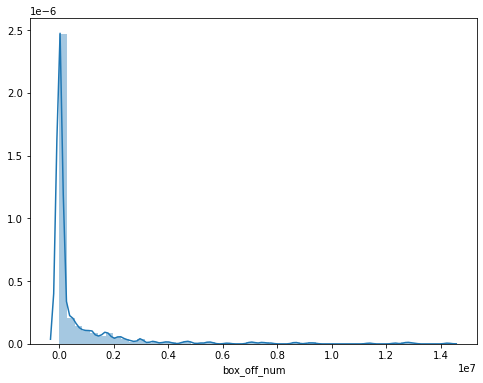

In [3]:
# box_off_num(타겟)의 왜도, 첨도를 그래프와 print로 알려주고 있다.

f, ax = plt.subplots(figsize = (8,6))
sns.distplot(train['box_off_num'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('box_off_num',train['box_off_num'].skew(), 
                                                     train['box_off_num'].kurt()))

In [4]:
#box_off_num 의 데이터를 log1p log화 해준 뒤 왜도와 첨도를 다시 구했다.

train['box_off_num'] = np.log1p(train['box_off_num'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('box_off_num',train['box_off_num'].skew(), 
                                                     train['box_off_num'].kurt()))

box_off_num -> Skewness: 0.133823, Kurtosis: -1.050213


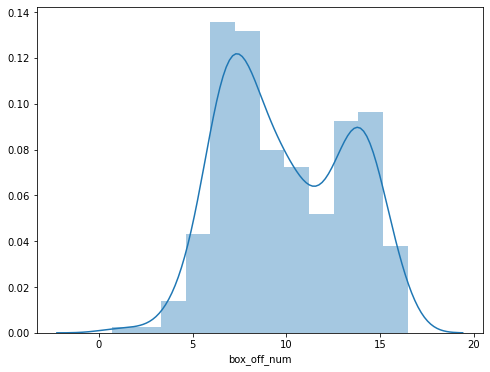

In [5]:
#정규분포와 비슷하게 box_off_num의 값이 재조정된 모습이다.

f, ax = plt.subplots(figsize = (8,6))
sns.distplot(train['box_off_num'])

dir_prev_bfnum이라는 feature값에 결측치가 존재한다는 것을 확인했다. 따라서 결측치를 채워주는 과정이 필요하다.

In [7]:
#train과 test를 합침

all_data = pd.concat([train, test], sort=False).reset_index(drop=True)

#Null count 확인
print('Null count :',all_data['dir_prev_bfnum'].isnull().sum())


Null count : 466


In [8]:
#dir_prev_bfnum에서 NaN값을 가지고 있는 데이터를 따로 만듬

bfnum_null = all_data[all_data['dir_prev_bfnum'].isnull()]

In [11]:
#NaN 값중 감독별 몇개의 영화를 찍었는지 확인

director_count = bfnum_null[['title','director']].groupby('director').count()
director_count = director_count.reset_index()
director_count

,director,title
0,New Pistol,1
1,강석필,1
2,강성옥,1
3,강우석,1
4,강의석,1
...,...,...
357,황병국,1
358,황석호,1
359,황욱,1
360,황윤,1


In [12]:
#영화가 1개인 경우는 이전의 영화가 없어서 NaN값일 수 도 있으므로 감독의 이름을 가져오기 위해
#또 새로운 데이터프레임을 만들고 해당하는 감독의 영화는 0으로 채워 넣는다.

dire_1 = director_count[director_count['title']==1]['director']
for name in dire_1:
    all_data.loc[all_data['director']==name, 'dir_prev_bfnum'] = all_data.loc[all_data['director']==name, 'dir_prev_bfnum'].fillna(0)

In [15]:
#영화가 1개인 경우를 0으로 채우고, 나머지 데이터중 NaN값인 갯수를 확인
all_data['dir_prev_bfnum'].isnull().sum()

174

In [19]:
#위와 똑같은 과정 반복

#한 감독이 2개 이상 만든 경우의 NaN 데이터프레임 생성

bfnum_null = all_data[all_data['dir_prev_bfnum'].isnull()]

director_count = bfnum_null[['title','director']].groupby('director').count()
director_count = director_count.reset_index()

director_count

,director,title
0,구혜선,3
1,김건,2
2,김경묵,2
3,김곡,2
4,김기덕,3
...,...,...
65,한지원,2
66,허은희,2
67,허철,2
68,홍상수,7


In [20]:
#관람객 수를 log취했기 때문에 원래대로 돌려 dir_prev_bfnum을 채우기 위한 용도로 사용.

all_data['box_off_num'] = np.expm1(all_data['box_off_num'])

In [21]:
#데이터를 순서대로 평균값을 계산하고 채워 넣을 수 있도록 사용자 정의 함수 만듬

def director_bfnum(all_director):
    #만약 첫번째 bfnum의 값이 있다면 그대로 두고, 없다면 다 0으로 채워 넣음
    
    if pd.isnull(all_director.iloc[0, 7]):
        all_director.iloc[0, 7] = 0 
    count = 1
    num = 0
 #시간순(release_time)으로 같은 감독이 과거에 만든 영화의 box_off_num을 더하여 갯수만큼 나눌 수 있는 평균을 구하도록함

    for i in range(1, len(all_director)):
        num += all_director['box_off_num'].iloc[i-1]
        bfnum = num/count
        all_director.iloc[i, 7] = bfnum
        count += 1
    return all_director

In [22]:
dire_2 = director_count['director']

#test데이터도 계산을 위해 nan값을 0의 값으로 가져온다.
#train과 test로 나눌 때 삭제해야함

all_data['box_off_num'].fillna(0, inplace=True)

for name in dire_2:
    all_director = all_data[all_data['director'] == name].sort_values('release_time')
    all_data[all_data['director']==name] = director_bfnum(all_director)

In [24]:
#원래의 데이터로 다 돌려줌

ntrain = len(train)
train = all_data[:ntrain]
test = all_data[ntrain:]
test.drop('box_off_num', axis=1, inplace=True)
train['box_off_num'] = np.log1p(train['box_off_num'])

In [33]:
#결측치 있는지 확인
train_null = train.drop('box_off_num', axis = 1).isnull().sum()
print(train.isnull().sum())
print(test.isnull().sum())

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64
title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64


dir_prev_bfnum -> Skewness: 4.418835, Kurtosis: 30.071183


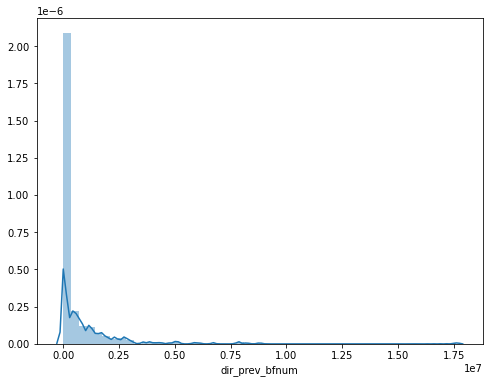

In [34]:
#dir_prv_bfnum 왜도와 첨도 확인
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(train['dir_prev_bfnum'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('dir_prev_bfnum',train_bfnum['dir_prev_bfnum'].skew(), 
                                                     train_bfnum['dir_prev_bfnum'].kurt()))

In [35]:
#dir_prev_bfnum의 채워준 값을 보고 log1p를 취해 재조정.
#왜도와 첨도 수정.

train['dir_prev_bfnum'] = np.log1p(train['dir_prev_bfnum'])
test['dir_prev_bfnum'] = np.log1p(test['dir_prev_bfnum'])
print("%s -> Skewness: %f, Kurtosis: %f" %  ('dir_prev_bfnum',train['dir_prev_bfnum'].skew(), 
                                                     train['dir_prev_bfnum'].kurt()))

dir_prev_bfnum -> Skewness: 0.194035, Kurtosis: -1.692858


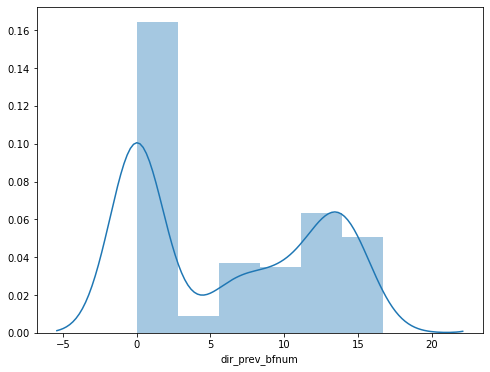

In [36]:
#그래프로 표현

f, ax = plt.subplots(figsize = (8,6))
sns.distplot(train['dir_prev_bfnum'])

In [37]:
#train과 test를 합침

all_data = pd.concat([train, test], sort=False).reset_index(drop=True)


In [40]:
#dir_prev_num이 0인데(감독이 전에 영화를 찍지 않았는데) dir_prev_bfnum을 가진 경우(과거 영화 흥행 기록이 있는 경우)를
#영화 수를 세서 알맞게 수정해줌


num_group = all_data[(all_data['dir_prev_num']==0) & 
                     (all_data['dir_prev_bfnum']>0)].groupby('director')[['dir_prev_num']].count().reset_index()

num_group

,director,dir_prev_num
0,구혜선,1
1,김건,1
2,김경묵,1
3,김곡,1
4,김기덕,2
5,김봉은,1
6,김석윤,1
7,김정환,1
8,김조광수,2
9,김종철,1


In [41]:
#전작품의 수가 1인 경우 원래 데이터에 dir_prev_num을 1로 수정해줌

dire_1 = num_group[num_group['dir_prev_num']==1]['director']

for name in dire_1:
    all_data.loc[all_data['director']==name, 'dir_prev_num'] = 1

In [43]:
#dir_prev_num 시간별로 정렬해서 몇번째 작품인지 인덱스 해줌
def director_num(prev_num):
    count = prev_num.iloc[0, 8]
    for i in range(1, len(prev_num)):
        prev_num.iloc[i, 8] = count
        count+=1
    return prev_num

director = all_data['director']
for name in director:
    prev_num = all_data[all_data['director'] == name].sort_values('release_time')
    all_data[all_data['director']==name] = director_num(prev_num)

In [44]:
#원래의 데이터로 다 돌려줌
ntrain = len(train)
train = all_data[:ntrain]
test = all_data[ntrain:]
test.drop('box_off_num', axis=1, inplace=True)

In [49]:
#이제부터 명목형 데이터를 수치형으로 변경해줌

#distributor(배급사)별로 평균 관객수를 확인해서 순서대로 encoding 해준다.

train_dist = train[['box_off_num','distributor']].groupby('distributor').mean().sort_values('box_off_num').reset_index()

dist_num = {}
for i in range(len(train_dist)):
    distributor = train_dist['distributor'].iloc[i]
    dist_num[distributor] = i

train_test_data = [train, test]
for dataset in train_test_data:
    dataset['distributor'] = dataset['distributor'].map(dist_num)

,distributor,box_off_num
0,인피니티엔터테인먼트,1.098612
1,고구마공작소,2.197225
2,사람과 사람들,3.761200
3,위드시네마,3.850148
4,나우콘텐츠,4.007333


In [52]:
#test에는 train의 distributor가 없는 경우도 있기때문에

#NaN값은 0으로 채워줌

test['distributor'].fillna(0, inplace = True)

In [53]:
#영어로 바꿈
replace_name = {'청소년 관람불가' : 'No Youth', '15세 관람가' : '15 years old', 
                        '전체 관람가' : 'G rating', '12세 관람가' : '12 years old' }
train.replace({'screening_rat' : replace_name}, inplace = True)
test.replace({'screening_rat' : replace_name}, inplace = True)
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,151,액션,2012-11-22,96,No Youth,조병옥,0.000000,0,91,2,10.060449
1,내부자들,165,느와르,2015-11-19,130,No Youth,우민호,13.965312,1,387,3,15.771725
2,은밀하게 위대하게,165,액션,2013-06-05,123,15 years old,장철수,12.304905,3,343,4,15.755558
3,나는 공무원이다,157,코미디,2012-07-12,101,G rating,구자홍,10.081425,2,20,6,12.291640
4,불량남녀,163,코미디,2010-11-04,108,15 years old,신근호,0.693147,1,251,2,13.088575


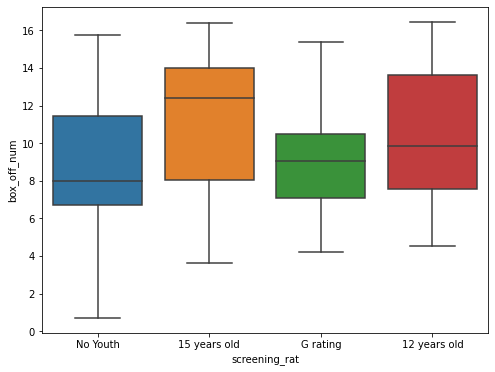

In [54]:
f, ax = plt.subplots(figsize = (8,6))
sns.boxplot(x='screening_rat', y='box_off_num', data=train[['screening_rat', 'box_off_num']])

In [55]:
train[['box_off_num','screening_rat']].groupby('screening_rat').mean()

,box_off_num
screening_rat,
12 years old,10.291901
15 years old,11.218375
G rating,8.943622
No Youth,8.982762


In [60]:
#genre(장르)별로 평균 관객수를 확인해서 순서대로 encoding 해준다.
train_genre = train[['box_off_num','genre']].groupby('genre').mean().sort_values('box_off_num').reset_index()
train_genre

genre_num = {}
for i in range(len(train_genre)):
    genre = train_genre['genre'].iloc[i]
    genre_num[genre] = i
    
train.replace({'genre' : genre_num}, inplace = True)
test.replace({'genre' : genre_num}, inplace = True)

In [62]:
train_test_data = [train, test]

for dataset in train_test_data:
    #date -> 년, 월, 일 단위로 새로운 칼럼 만듦
    dataset['release_time'] = dataset['release_time'].map(lambda x : x.replace('-', ''))
    dataset['year'] = dataset['release_time'].str[:4]
    dataset['year'] = dataset['year'].astype(int)
    dataset['month'] = dataset['release_time'].str[4:6]
    dataset['month'] = dataset['month'].astype(int)
    dataset['day'] = dataset['release_time'].str[6:8]
    dataset['day'] = dataset['day'].astype(int)
    dataset['release_time'] = dataset['release_time'].astype(int)


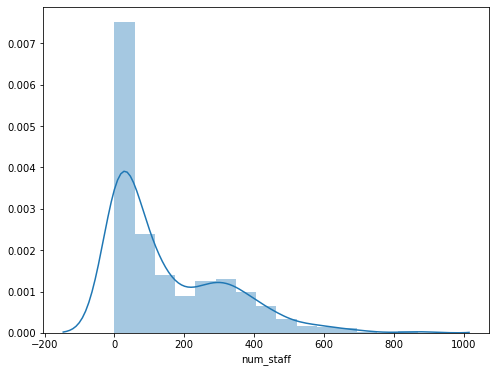

In [64]:
#데이터별로 왜도와 첨도 확인
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(train['num_staff'])

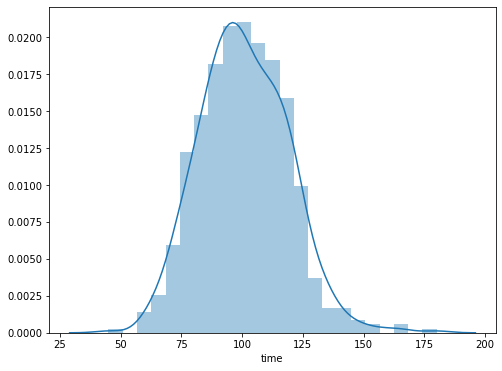

In [65]:
#데이터별로 왜도와 첨도 확인
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(train['time'])

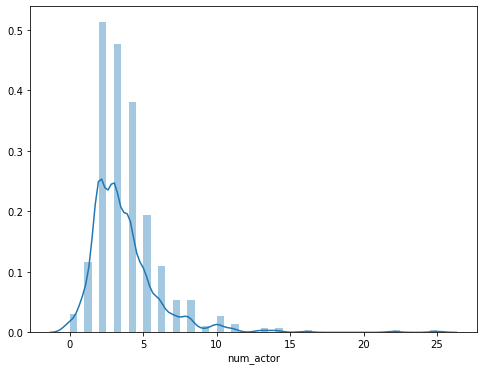

In [66]:
#데이터별로 왜도와 첨도 확인
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(train['num_actor'])


In [68]:
#screening_rat, director 이라는 범주형 특징값들을 수치형으로 encoding해줬다.

from sklearn.preprocessing import LabelEncoder
cols = ['screening_rat', 'director']

ntrain = len(train)

all_data = pd.concat([train, test], sort=False).reset_index(drop=True)
target = train['box_off_num']
all_data.drop(['box_off_num', 'title'], axis=1, inplace=True)

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [69]:
#데이터를 원래대로 돌려줬다.
ntrain = len(train)
train = all_data[:ntrain]
test = all_data[ntrain:]

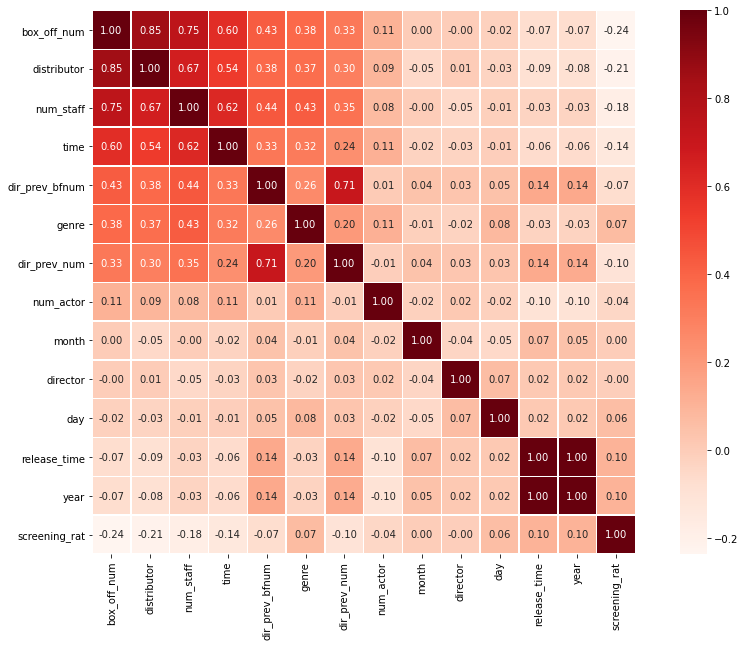

In [70]:
#상관관계 확인
k=20 #히트맵 변수 갯수
train = pd.concat([train, target], axis=1)
corrmat = train.corr() #변수간의 상관관계
cols = corrmat.nlargest(k, 'box_off_num')['box_off_num'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [71]:
#배우 1명당 스태프수라는 새로운 특징값 생성

train_test_data = [train, test]
for dataset in train_test_data:
    #배우 1명당 스태프수
    dataset['staff_per_actor'] = 0
    dataset.loc[dataset['num_actor']>0, 'staff_per_actor'] = dataset['num_staff']/dataset['num_actor']

In [72]:
#감독은 의미 없어보여서
train = train.drop(['director'], axis= 1)
test = test.drop([ 'director'], axis= 1)

In [73]:
#특징값들 중에 왜도와 첨도가 많이 이상한 것들을 확인
train_columns = []
for column in train.columns[:]:
    if (train[column].skew() >= 1) | (train[column].skew() <= -1):
        print("%s -> Skewness: %f, Kurtosis: %f" %  (column,train[column].skew(), 
                                                 train[column].kurt()))
        train_columns.append(column)
    elif (train[column].kurt() >= 3) | (train[column].kurt() <= -3):
        print("%s -> Skewness: %f, Kurtosis: %f" %  (column,train[column].skew(), 
                                                 train[column].kurt()))
        train_columns.append(column)

dir_prev_num -> Skewness: 1.113956, Kurtosis: 0.917023
num_staff -> Skewness: 1.233452, Kurtosis: 1.103669
num_actor -> Skewness: 2.950668, Kurtosis: 16.615141
staff_per_actor -> Skewness: 2.591732, Kurtosis: 12.332139


In [75]:
#첨도와 왜도를 자연로그를 취해줌으로서 조정

for column in train_columns :
    train[column] = np.log1p(train[column])
    test[column] = np.log1p(test[column])
    print("%s -> Skewness: %f, Kurtosis: %f" %  (column,train[column].skew(), 
                                                 train[column].kurt()))

dir_prev_num -> Skewness: 0.330087, Kurtosis: -1.158590
num_staff -> Skewness: -0.706262, Kurtosis: -0.474679
num_actor -> Skewness: 0.062556, Kurtosis: 1.580372
staff_per_actor -> Skewness: -0.377595, Kurtosis: -0.932713


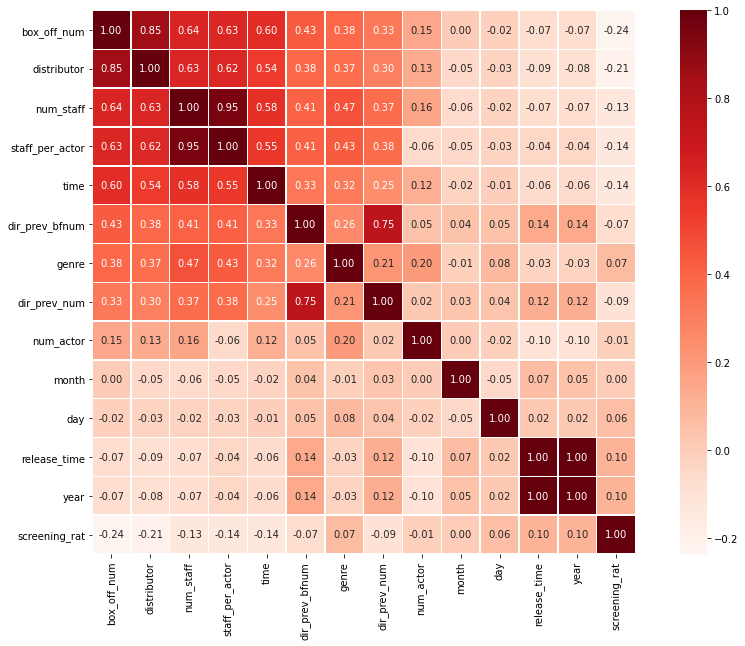

In [76]:
#왜도와 첨도를 조정함으로서 히트맵 변경 확인

k=20 #히트맵 변수 갯수
corrmat = train.corr() #변수간의 상관관계
cols = corrmat.nlargest(k, 'box_off_num')['box_off_num'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [78]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [79]:
target = train['box_off_num']
del train['box_off_num']

In [160]:
#스코어 확인을 위한 함수를 정의(스코어는 dacon평가 기준인 RMSE를 사용) - k-fold 기법
n_folds = 5


def score(model):
    kfold = KFold(n_splits=n_folds, shuffle=True ,random_state=999).get_n_splits(train.values)
    rmse = np.mean(np.sqrt(-cross_val_score(model, train.values, np.expm1(target), scoring = "neg_mean_squared_error", cv = kfold)))
    print("{} : {:.4f}".format(model, rmse))

In [161]:
#모델 2개의 객체 생성
xgboost = xgb.XGBRegressor(random_state=999)
lightgbm = lgb.LGBMRegressor(random_state=999)

In [162]:
#점수확인
score(xgboost)
score(lightgbm)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=999, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) : 1576466.0064
LGBMRegressor(random_state=999) : 1475281.5238


In [147]:
#점수가 비슷한 관계로 2개의 모델을 학습시킨다.

xgboost.fit(train.values, target)
lightgbm.fit(train.values, target)

LGBMRegressor(random_state=999)

In [148]:
#featrue_importances_를 확인해서 필요없는 특징값 확인
for i in range(13):
    print(train.columns[i],"\n", "lightGBM : ", lightgbm.feature_importances_[i], "xgBoost : ",xgboost.feature_importances_[i])

distributor 
 lightGBM :  294 xgBoost :  0.6243403
genre 
 lightGBM :  105 xgBoost :  0.022672724
release_time 
 lightGBM :  288 xgBoost :  0.024278617
time 
 lightGBM :  288 xgBoost :  0.052080315
screening_rat 
 lightGBM :  66 xgBoost :  0.02202032
dir_prev_bfnum 
 lightGBM :  147 xgBoost :  0.02605245
dir_prev_num 
 lightGBM :  31 xgBoost :  0.02153608
num_staff 
 lightGBM :  283 xgBoost :  0.080664635
num_actor 
 lightGBM :  102 xgBoost :  0.033623233
year 
 lightGBM :  0 xgBoost :  0.0
month 
 lightGBM :  135 xgBoost :  0.044536944
day 
 lightGBM :  239 xgBoost :  0.0219149
staff_per_actor 
 lightGBM :  211 xgBoost :  0.026279505


In [149]:
#필요없는 feature값 삭제 후 모델학습

test.drop('year', axis=1, inplace=True)
train.drop('year', axis=1, inplace=True)

xgboost.fit(train.values, target)
lightgbm.fit(train.values, target)

LGBMRegressor(random_state=999)

In [187]:
#feature을 모든 경우의 수를 테스트 하는 방법으로 더 안좋은 결과를 가져오는 것을 삭제함.
# model = xgboost 

ex_train = train.copy()
final = []
k = 0
kfold = KFold(n_splits=n_folds, shuffle=True ,random_state=999).get_n_splits(train.values)

for f1 in range(0,2):
    if(f1==1): 
        del ex_train['distributor']
    else:
        ex_train['distributor'] = train.iloc[:,0]
    for f2 in range(0,2):
        if(f2==1): 
            del ex_train['genre']        
        else:
            ex_train['genre'] = train.iloc[:,1]
        for f3 in range(0,2):
            if(f3==1): 
                del ex_train['release_time']    
            else:
                ex_train['release_time'] = train.iloc[:,2]
            for f4 in range(0,2):
                if(f4==1): 
                    del ex_train['time']     
                else:
                    ex_train['time'] = train.iloc[:,3]
                for f5 in range(0,2):
                    if(f5==1): 
                        del ex_train['screening_rat']          
                    else:
                        ex_train['screening_rat'] = train.iloc[:,4]
                    for f6 in range(0,2):
                        if(f6==1): 
                            del ex_train['dir_prev_bfnum']          
                        else:
                            ex_train['dir_prev_bfnum'] = train.iloc[:,5]
                        for f7 in range(0,2):
                            if(f7==1): 
                                del ex_train['dir_prev_num']     
                            else:
                                ex_train['dir_prev_num'] = train.iloc[:,6]     
                            for f8 in range(0,2):
                                if(f8==1): 
                                    del ex_train['num_staff']        
                                else:
                                    ex_train['num_staff'] = train.iloc[:,7]  
                                for f9 in range(0,2):
                                    if(f9==1): 
                                        del ex_train['num_actor']       
                                    else:
                                        ex_train['num_actor'] = train.iloc[:,8]  
                                    for f11 in range(0,2):
                                        if(f11==1): 
                                            del ex_train['month']          
                                        else:
                                            ex_train['month'] = train.iloc[:,9]
                                        for f12 in range(0,2):
                                            if(f12==1): 
                                                del ex_train['day']       
                                            else:
                                                ex_train['day'] = train.iloc[:,10]   
                                            for f13 in range(0,2):
                                                if(f13==1): 
                                                    del ex_train['staff_per_actor']        
                                                else:
                                                    ex_train['staff_per_actor'] = train.iloc[:,11]  

                                                print(f1,f2,f3,f4,f5,f6,f7,f8,f9,f11,f12,f13)
                                                xgboost.fit(ex_train.values, target)
                                                final.append(np.mean(np.sqrt(-cross_val_score(xgboost, ex_train.values, np.expm1(target), scoring = "neg_mean_squared_error", cv = kfold))))
                                                print(final[k])
                                                k+=1

0 0 0 0 0 0 0 0 0 0 0 0
1576466.0064046145
0 0 0 0 0 0 0 0 0 0 0 1
1601029.5213085925
0 0 0 0 0 0 0 0 0 0 1 0
1616727.4681997574
0 0 0 0 0 0 0 0 0 0 1 1
1610622.8007715745
0 0 0 0 0 0 0 0 0 1 0 0
1572865.2944002755
0 0 0 0 0 0 0 0 0 1 0 1
1566821.5418967202
0 0 0 0 0 0 0 0 0 1 1 0
1555925.4360460197
0 0 0 0 0 0 0 0 0 1 1 1
1539512.826772488
0 0 0 0 0 0 0 0 1 0 0 0
1601012.297278668
0 0 0 0 0 0 0 0 1 0 0 1
1607157.233854664
0 0 0 0 0 0 0 0 1 0 1 0
1625100.002967333
0 0 0 0 0 0 0 0 1 0 1 1
1589330.1597381947
0 0 0 0 0 0 0 0 1 1 0 0
1585365.6260041054
0 0 0 0 0 0 0 0 1 1 0 1
1589622.448237142
0 0 0 0 0 0 0 0 1 1 1 0
1590785.078210956
0 0 0 0 0 0 0 0 1 1 1 1
1594346.5167203632
0 0 0 0 0 0 0 1 0 0 0 0
1653842.1921224415
0 0 0 0 0 0 0 1 0 0 0 1
1609904.0226765287
0 0 0 0 0 0 0 1 0 0 1 0
1711119.5523093282
0 0 0 0 0 0 0 1 0 0 1 1
1629494.7357871137
0 0 0 0 0 0 0 1 0 1 0 0
1730437.0582460482
0 0 0 0 0 0 0 1 0 1 0 1
1698703.595433541
0 0 0 0 0 0 0 1 0 1 1 0
1724926.0529489282
0 0 0 0 0 0 0 1 0 

1643879.864884726
0 0 0 0 1 1 0 0 0 0 0 1
1619807.0963248299
0 0 0 0 1 1 0 0 0 0 1 0
1688606.4675027183
0 0 0 0 1 1 0 0 0 0 1 1
1679166.1495276291
0 0 0 0 1 1 0 0 0 1 0 0
1581613.5338043808
0 0 0 0 1 1 0 0 0 1 0 1
1571056.2029632437
0 0 0 0 1 1 0 0 0 1 1 0
1620386.5953382677
0 0 0 0 1 1 0 0 0 1 1 1
1616501.2354025755
0 0 0 0 1 1 0 0 1 0 0 0
1649056.0877792996
0 0 0 0 1 1 0 0 1 0 0 1
1607193.5174545397
0 0 0 0 1 1 0 0 1 0 1 0
1678125.638811574
0 0 0 0 1 1 0 0 1 0 1 1
1626165.1956478555
0 0 0 0 1 1 0 0 1 1 0 0
1685924.1682880584
0 0 0 0 1 1 0 0 1 1 0 1
1641144.1951207756
0 0 0 0 1 1 0 0 1 1 1 0
1650490.4716959924
0 0 0 0 1 1 0 0 1 1 1 1
1715131.464459464
0 0 0 0 1 1 0 1 0 0 0 0
1588231.15307414
0 0 0 0 1 1 0 1 0 0 0 1
1637923.7832977374
0 0 0 0 1 1 0 1 0 0 1 0
1664670.4089072547
0 0 0 0 1 1 0 1 0 0 1 1
1651606.1094014135
0 0 0 0 1 1 0 1 0 1 0 0
1725456.1285101064
0 0 0 0 1 1 0 1 0 1 0 1
1731075.1210182686
0 0 0 0 1 1 0 1 0 1 1 0
1776381.3831234835
0 0 0 0 1 1 0 1 0 1 1 1
1745059.38228666

1649995.363614895
0 0 0 1 1 0 0 0 0 0 0 1
1649468.1906290425
0 0 0 1 1 0 0 0 0 0 1 0
1624361.8703569614
0 0 0 1 1 0 0 0 0 0 1 1
1584377.0276216352
0 0 0 1 1 0 0 0 0 1 0 0
1765859.7681009248
0 0 0 1 1 0 0 0 0 1 0 1
1735640.3193937507
0 0 0 1 1 0 0 0 0 1 1 0
1681740.5038097426
0 0 0 1 1 0 0 0 0 1 1 1
1646987.9853379321
0 0 0 1 1 0 0 0 1 0 0 0
1637347.9347272443
0 0 0 1 1 0 0 0 1 0 0 1
1696679.5991548293
0 0 0 1 1 0 0 0 1 0 1 0
1629912.3556351578
0 0 0 1 1 0 0 0 1 0 1 1
1655660.3247771203
0 0 0 1 1 0 0 0 1 1 0 0
1735521.469305227
0 0 0 1 1 0 0 0 1 1 0 1
1761901.7425242066
0 0 0 1 1 0 0 0 1 1 1 0
1750591.8109284514
0 0 0 1 1 0 0 0 1 1 1 1
1685441.7014721758
0 0 0 1 1 0 0 1 0 0 0 0
1754462.8198518592
0 0 0 1 1 0 0 1 0 0 0 1
1861746.0933367629
0 0 0 1 1 0 0 1 0 0 1 0
1772823.9964011826
0 0 0 1 1 0 0 1 0 0 1 1
1869599.749556505
0 0 0 1 1 0 0 1 0 1 0 0
1712423.0790406142
0 0 0 1 1 0 0 1 0 1 0 1
1853641.3627061397
0 0 0 1 1 0 0 1 0 1 1 0
1752369.5604747548
0 0 0 1 1 0 0 1 0 1 1 1
1933185.227957

1716457.437881713
0 0 1 0 0 1 0 0 0 0 0 1
1722961.3798986026
0 0 1 0 0 1 0 0 0 0 1 0
1660642.6776636464
0 0 1 0 0 1 0 0 0 0 1 1
1776655.4753444444
0 0 1 0 0 1 0 0 0 1 0 0
1671210.60157021
0 0 1 0 0 1 0 0 0 1 0 1
1706514.3840200813
0 0 1 0 0 1 0 0 0 1 1 0
1652100.3360835856
0 0 1 0 0 1 0 0 0 1 1 1
1666384.1676322161
0 0 1 0 0 1 0 0 1 0 0 0
1657698.649771457
0 0 1 0 0 1 0 0 1 0 0 1
1727659.712681086
0 0 1 0 0 1 0 0 1 0 1 0
1686488.662260969
0 0 1 0 0 1 0 0 1 0 1 1
1779390.676899713
0 0 1 0 0 1 0 0 1 1 0 0
1703982.1047210214
0 0 1 0 0 1 0 0 1 1 0 1
1762777.8756660423
0 0 1 0 0 1 0 0 1 1 1 0
1703846.0524352281
0 0 1 0 0 1 0 0 1 1 1 1
1767451.833837051
0 0 1 0 0 1 0 1 0 0 0 0
1749481.3965736874
0 0 1 0 0 1 0 1 0 0 0 1
1817661.7837619886
0 0 1 0 0 1 0 1 0 0 1 0
1749115.5021790746
0 0 1 0 0 1 0 1 0 0 1 1
1816388.2058760773
0 0 1 0 0 1 0 1 0 1 0 0
1802804.200034894
0 0 1 0 0 1 0 1 0 1 0 1
1821358.8512862336
0 0 1 0 0 1 0 1 0 1 1 0
1841342.5520819766
0 0 1 0 0 1 0 1 0 1 1 1
1820177.9234240588
0

1696452.9790142209
0 0 1 1 0 0 0 0 0 0 0 1
1609057.1158357833
0 0 1 1 0 0 0 0 0 0 1 0
1652599.5337366485
0 0 1 1 0 0 0 0 0 0 1 1
1659019.8822710647
0 0 1 1 0 0 0 0 0 1 0 0
1674251.5064138318
0 0 1 1 0 0 0 0 0 1 0 1
1766221.376536286
0 0 1 1 0 0 0 0 0 1 1 0
1693971.9216966038
0 0 1 1 0 0 0 0 0 1 1 1
1712100.0984890044
0 0 1 1 0 0 0 0 1 0 0 0
1698679.2836222108
0 0 1 1 0 0 0 0 1 0 0 1
1731017.6934264605
0 0 1 1 0 0 0 0 1 0 1 0
1665021.0214482546
0 0 1 1 0 0 0 0 1 0 1 1
1734091.6922239207
0 0 1 1 0 0 0 0 1 1 0 0
1696958.9113787182
0 0 1 1 0 0 0 0 1 1 0 1
1701847.75889231
0 0 1 1 0 0 0 0 1 1 1 0
1673482.28726908
0 0 1 1 0 0 0 0 1 1 1 1
1760462.4801453326
0 0 1 1 0 0 0 1 0 0 0 0
1689516.9624904245
0 0 1 1 0 0 0 1 0 0 0 1
1775441.7098028935
0 0 1 1 0 0 0 1 0 0 1 0
1690236.4844637022
0 0 1 1 0 0 0 1 0 0 1 1
1750428.344257284
0 0 1 1 0 0 0 1 0 1 0 0
1779731.1444079478
0 0 1 1 0 0 0 1 0 1 0 1
1875938.5063276782
0 0 1 1 0 0 0 1 0 1 1 0
1806476.4446806058
0 0 1 1 0 0 0 1 0 1 1 1
2005944.409091723

1707505.094026344
0 0 1 1 1 1 0 0 0 0 0 1
1659608.4936913655
0 0 1 1 1 1 0 0 0 0 1 0
1757428.6627689544
0 0 1 1 1 1 0 0 0 0 1 1
1720700.4812903248
0 0 1 1 1 1 0 0 0 1 0 0
1834002.709709889
0 0 1 1 1 1 0 0 0 1 0 1
1826916.0094391932
0 0 1 1 1 1 0 0 0 1 1 0
1785933.2972562648
0 0 1 1 1 1 0 0 0 1 1 1
1881429.3701689919
0 0 1 1 1 1 0 0 1 0 0 0
1724504.2929043553
0 0 1 1 1 1 0 0 1 0 0 1
1814990.7454873822
0 0 1 1 1 1 0 0 1 0 1 0
1690622.3354310181
0 0 1 1 1 1 0 0 1 0 1 1
1799046.576114817
0 0 1 1 1 1 0 0 1 1 0 0
1800582.4687592662
0 0 1 1 1 1 0 0 1 1 0 1
1856786.333552235
0 0 1 1 1 1 0 0 1 1 1 0
1713431.3200682472
0 0 1 1 1 1 0 0 1 1 1 1
1878290.3419562946
0 0 1 1 1 1 0 1 0 0 0 0
1731623.4782922827
0 0 1 1 1 1 0 1 0 0 0 1
1768266.790371531
0 0 1 1 1 1 0 1 0 0 1 0
1765423.5138685857
0 0 1 1 1 1 0 1 0 0 1 1
1889661.5598388866
0 0 1 1 1 1 0 1 0 1 0 0
1727988.8570092632
0 0 1 1 1 1 0 1 0 1 0 1
2127328.5443329606
0 0 1 1 1 1 0 1 0 1 1 0
1763721.5405786908
0 0 1 1 1 1 0 1 0 1 1 1
2046135.47337210

1612292.0612094195
0 1 0 0 1 0 0 0 0 0 0 1
1679727.3643689174
0 1 0 0 1 0 0 0 0 0 1 0
1678291.3987793284
0 1 0 0 1 0 0 0 0 0 1 1
1675458.5628711293
0 1 0 0 1 0 0 0 0 1 0 0
1674904.6443877225
0 1 0 0 1 0 0 0 0 1 0 1
1664981.1375563964
0 1 0 0 1 0 0 0 0 1 1 0
1672614.9724640958
0 1 0 0 1 0 0 0 0 1 1 1
1628778.2209037151
0 1 0 0 1 0 0 0 1 0 0 0
1679724.4218169742
0 1 0 0 1 0 0 0 1 0 0 1
1642055.661979188
0 1 0 0 1 0 0 0 1 0 1 0
1675644.8873720076
0 1 0 0 1 0 0 0 1 0 1 1
1700331.7799307231
0 1 0 0 1 0 0 0 1 1 0 0
1617085.497483037
0 1 0 0 1 0 0 0 1 1 0 1
1659377.1804786336
0 1 0 0 1 0 0 0 1 1 1 0
1675555.531912461
0 1 0 0 1 0 0 0 1 1 1 1
1648115.3096791953
0 1 0 0 1 0 0 1 0 0 0 0
1737830.8484105978
0 1 0 0 1 0 0 1 0 0 0 1
1727162.0001749988
0 1 0 0 1 0 0 1 0 0 1 0
1811923.4283265676
0 1 0 0 1 0 0 1 0 0 1 1
1778413.2028686926
0 1 0 0 1 0 0 1 0 1 0 0
1702432.4809943386
0 1 0 0 1 0 0 1 0 1 0 1
1831044.560643992
0 1 0 0 1 0 0 1 0 1 1 0
1750020.4796350058
0 1 0 0 1 0 0 1 0 1 1 1
1810144.7454643

1684270.8309315792
0 1 0 1 0 1 0 0 0 0 0 1
1621817.0296545469
0 1 0 1 0 1 0 0 0 0 1 0
1622538.9853288983
0 1 0 1 0 1 0 0 0 0 1 1
1645952.3837712707
0 1 0 1 0 1 0 0 0 1 0 0
1667344.000706007
0 1 0 1 0 1 0 0 0 1 0 1
1656178.7800140772
0 1 0 1 0 1 0 0 0 1 1 0
1713867.8936031274
0 1 0 1 0 1 0 0 0 1 1 1
1762387.4157602687
0 1 0 1 0 1 0 0 1 0 0 0
1681885.1068914323
0 1 0 1 0 1 0 0 1 0 0 1
1681528.414135369
0 1 0 1 0 1 0 0 1 0 1 0
1653715.3637909836
0 1 0 1 0 1 0 0 1 0 1 1
1712095.588797037
0 1 0 1 0 1 0 0 1 1 0 0
1689303.271457885
0 1 0 1 0 1 0 0 1 1 0 1
1770510.2761448547
0 1 0 1 0 1 0 0 1 1 1 0
1680247.0406842276
0 1 0 1 0 1 0 0 1 1 1 1
1714833.598022702
0 1 0 1 0 1 0 1 0 0 0 0
1740278.144777365
0 1 0 1 0 1 0 1 0 0 0 1
1816882.4409709335
0 1 0 1 0 1 0 1 0 0 1 0
1769902.6001565722
0 1 0 1 0 1 0 1 0 0 1 1
1756249.3221760404
0 1 0 1 0 1 0 1 0 1 0 0
1725047.162640396
0 1 0 1 0 1 0 1 0 1 0 1
1750084.22830719
0 1 0 1 0 1 0 1 0 1 1 0
1704742.026010178
0 1 0 1 0 1 0 1 0 1 1 1
1834948.6505855203
0 

1700751.6436174836
0 1 1 0 0 0 0 0 0 0 0 1
1752885.535503776
0 1 1 0 0 0 0 0 0 0 1 0
1641560.1185291382
0 1 1 0 0 0 0 0 0 0 1 1
1723444.7817576006
0 1 1 0 0 0 0 0 0 1 0 0
1655948.8840053002
0 1 1 0 0 0 0 0 0 1 0 1
1681138.7648476665
0 1 1 0 0 0 0 0 0 1 1 0
1625609.159896545
0 1 1 0 0 0 0 0 0 1 1 1
1717422.1820512854
0 1 1 0 0 0 0 0 1 0 0 0
1704516.818863359
0 1 1 0 0 0 0 0 1 0 0 1
1776985.0431227013
0 1 1 0 0 0 0 0 1 0 1 0
1606200.7818693495
0 1 1 0 0 0 0 0 1 0 1 1
1747455.8931023623
0 1 1 0 0 0 0 0 1 1 0 0
1647390.4264648897
0 1 1 0 0 0 0 0 1 1 0 1
1667617.892719417
0 1 1 0 0 0 0 0 1 1 1 0
1620061.1592522338
0 1 1 0 0 0 0 0 1 1 1 1
1690752.328086401
0 1 1 0 0 0 0 1 0 0 0 0
1726441.4638890282
0 1 1 0 0 0 0 1 0 0 0 1
1743712.3315391853
0 1 1 0 0 0 0 1 0 0 1 0
1736457.7478928522
0 1 1 0 0 0 0 1 0 0 1 1
1720168.7722047423
0 1 1 0 0 0 0 1 0 1 0 0
1769554.0633593805
0 1 1 0 0 0 0 1 0 1 0 1
1778750.9768029384
0 1 1 0 0 0 0 1 0 1 1 0
1699505.030258925
0 1 1 0 0 0 0 1 0 1 1 1
1774315.959893788

1763288.4863632931
0 1 1 0 1 1 0 0 0 0 0 1
1752440.0208205525
0 1 1 0 1 1 0 0 0 0 1 0
1709244.889936807
0 1 1 0 1 1 0 0 0 0 1 1
1847809.107106873
0 1 1 0 1 1 0 0 0 1 0 0
1682277.4604832672
0 1 1 0 1 1 0 0 0 1 0 1
1814019.9577317373
0 1 1 0 1 1 0 0 0 1 1 0
1712990.6662288117
0 1 1 0 1 1 0 0 0 1 1 1
1778398.7161187665
0 1 1 0 1 1 0 0 1 0 0 0
1754408.1699458968
0 1 1 0 1 1 0 0 1 0 0 1
1810902.3977557905
0 1 1 0 1 1 0 0 1 0 1 0
1735990.8691015088
0 1 1 0 1 1 0 0 1 0 1 1
1807761.6251509048
0 1 1 0 1 1 0 0 1 1 0 0
1681081.0048580144
0 1 1 0 1 1 0 0 1 1 0 1
1815161.5581999477
0 1 1 0 1 1 0 0 1 1 1 0
1690180.2168456633
0 1 1 0 1 1 0 0 1 1 1 1
1743734.8529343395
0 1 1 0 1 1 0 1 0 0 0 0
1831899.8850545897
0 1 1 0 1 1 0 1 0 0 0 1
1868004.4436518215
0 1 1 0 1 1 0 1 0 0 1 0
1780588.1933316118
0 1 1 0 1 1 0 1 0 0 1 1
1926302.6477477984
0 1 1 0 1 1 0 1 0 1 0 0
1771404.8494437549
0 1 1 0 1 1 0 1 0 1 0 1
1886013.8989731178
0 1 1 0 1 1 0 1 0 1 1 0
1785285.589738033
0 1 1 0 1 1 0 1 0 1 1 1
1857674.901900

1696224.3012499511
0 1 1 1 1 0 0 0 0 0 0 1
1708339.83360815
0 1 1 1 1 0 0 0 0 0 1 0
1748903.2863369808
0 1 1 1 1 0 0 0 0 0 1 1
1719343.9693776332
0 1 1 1 1 0 0 0 0 1 0 0
1708953.303991589
0 1 1 1 1 0 0 0 0 1 0 1
1784006.042318094
0 1 1 1 1 0 0 0 0 1 1 0
1789959.9042531005
0 1 1 1 1 0 0 0 0 1 1 1
1826152.845479096
0 1 1 1 1 0 0 0 1 0 0 0
1678986.3315134323
0 1 1 1 1 0 0 0 1 0 0 1
1723537.5626379426
0 1 1 1 1 0 0 0 1 0 1 0
1653063.57837886
0 1 1 1 1 0 0 0 1 0 1 1
1679653.9242232745
0 1 1 1 1 0 0 0 1 1 0 0
1743085.8800806091
0 1 1 1 1 0 0 0 1 1 0 1
1780458.2076632492
0 1 1 1 1 0 0 0 1 1 1 0
1690216.543512433
0 1 1 1 1 0 0 0 1 1 1 1
1782061.2098348197
0 1 1 1 1 0 0 1 0 0 0 0
1792555.506012813
0 1 1 1 1 0 0 1 0 0 0 1
1797493.5423079655
0 1 1 1 1 0 0 1 0 0 1 0
1767459.6950128041
0 1 1 1 1 0 0 1 0 0 1 1
1918826.9939693317
0 1 1 1 1 0 0 1 0 1 0 0
1882270.7421890676
0 1 1 1 1 0 0 1 0 1 0 1
2036268.8813334785
0 1 1 1 1 0 0 1 0 1 1 0
1835248.260346743
0 1 1 1 1 0 0 1 0 1 1 1
2127662.437531598
0 1

1525026.8242377557
1 0 0 0 0 1 0 0 0 0 0 1
1574749.8640912238
1 0 0 0 0 1 0 0 0 0 1 0
1646899.8742403365
1 0 0 0 0 1 0 0 0 0 1 1
1697392.029617931
1 0 0 0 0 1 0 0 0 1 0 0
1596973.3429803404
1 0 0 0 0 1 0 0 0 1 0 1
1574021.6806873041
1 0 0 0 0 1 0 0 0 1 1 0
1667570.9923048492
1 0 0 0 0 1 0 0 0 1 1 1
1614525.0986852902
1 0 0 0 0 1 0 0 1 0 0 0
1598970.568852886
1 0 0 0 0 1 0 0 1 0 0 1
1626484.5139148696
1 0 0 0 0 1 0 0 1 0 1 0
1703759.247587373
1 0 0 0 0 1 0 0 1 0 1 1
1691902.169520285
1 0 0 0 0 1 0 0 1 1 0 0
1662305.489236336
1 0 0 0 0 1 0 0 1 1 0 1
1592312.8664451316
1 0 0 0 0 1 0 0 1 1 1 0
1718202.133932899
1 0 0 0 0 1 0 0 1 1 1 1
1707295.373741698
1 0 0 0 0 1 0 1 0 0 0 0
1670529.9225749788
1 0 0 0 0 1 0 1 0 0 0 1
1659286.31281785
1 0 0 0 0 1 0 1 0 0 1 0
1712177.9334599643
1 0 0 0 0 1 0 1 0 0 1 1
1734361.806593993
1 0 0 0 0 1 0 1 0 1 0 0
1692178.1221854433
1 0 0 0 0 1 0 1 0 1 0 1
1784418.5193206905
1 0 0 0 0 1 0 1 0 1 1 0
1744745.606495826
1 0 0 0 0 1 0 1 0 1 1 1
1811134.5521607574
1 0

1636500.217874778
1 0 0 1 0 0 0 0 0 0 0 1
1674869.7115191824
1 0 0 1 0 0 0 0 0 0 1 0
1659452.1660858027
1 0 0 1 0 0 0 0 0 0 1 1
1701077.5656185858
1 0 0 1 0 0 0 0 0 1 0 0
1660376.516431022
1 0 0 1 0 0 0 0 0 1 0 1
1690268.7214682563
1 0 0 1 0 0 0 0 0 1 1 0
1631833.8992172848
1 0 0 1 0 0 0 0 0 1 1 1
1688743.3239191684
1 0 0 1 0 0 0 0 1 0 0 0
1679558.3317634768
1 0 0 1 0 0 0 0 1 0 0 1
1730384.3140235625
1 0 0 1 0 0 0 0 1 0 1 0
1715438.2301252398
1 0 0 1 0 0 0 0 1 0 1 1
1667958.729985592
1 0 0 1 0 0 0 0 1 1 0 0
1665698.013260202
1 0 0 1 0 0 0 0 1 1 0 1
1687204.2784473605
1 0 0 1 0 0 0 0 1 1 1 0
1696778.4126530006
1 0 0 1 0 0 0 0 1 1 1 1
1699225.6244446211
1 0 0 1 0 0 0 1 0 0 0 0
1851888.8152541905
1 0 0 1 0 0 0 1 0 0 0 1
1965124.3444606767
1 0 0 1 0 0 0 1 0 0 1 0
1846041.3409814225
1 0 0 1 0 0 0 1 0 0 1 1
2040197.7477197596
1 0 0 1 0 0 0 1 0 1 0 0
1799292.8968575639
1 0 0 1 0 0 0 1 0 1 0 1
1876164.4801345065
1 0 0 1 0 0 0 1 0 1 1 0
1836647.5506794737
1 0 0 1 0 0 0 1 0 1 1 1
2052162.3182870

1762453.736576549
1 0 0 1 1 1 0 0 0 0 0 1
1761573.9420100406
1 0 0 1 1 1 0 0 0 0 1 0
1784959.069113342
1 0 0 1 1 1 0 0 0 0 1 1
1837147.067022177
1 0 0 1 1 1 0 0 0 1 0 0
1860567.4369047307
1 0 0 1 1 1 0 0 0 1 0 1
1878947.4226694289
1 0 0 1 1 1 0 0 0 1 1 0
1849455.1874072398
1 0 0 1 1 1 0 0 0 1 1 1
1919473.3235312551
1 0 0 1 1 1 0 0 1 0 0 0
1734215.442664782
1 0 0 1 1 1 0 0 1 0 0 1
1851945.7372197104
1 0 0 1 1 1 0 0 1 0 1 0
1747682.9951201554
1 0 0 1 1 1 0 0 1 0 1 1
1890298.0273958954
1 0 0 1 1 1 0 0 1 1 0 0
1849517.2866689265
1 0 0 1 1 1 0 0 1 1 0 1
1927155.3401815556
1 0 0 1 1 1 0 0 1 1 1 0
1856824.7349642073
1 0 0 1 1 1 0 0 1 1 1 1
1962822.1639178463
1 0 0 1 1 1 0 1 0 0 0 0
1760107.3205756496
1 0 0 1 1 1 0 1 0 0 0 1
2028841.8140627667
1 0 0 1 1 1 0 1 0 0 1 0
1874876.9824559751
1 0 0 1 1 1 0 1 0 0 1 1
2216427.949216432
1 0 0 1 1 1 0 1 0 1 0 0
1747237.4792348004
1 0 0 1 1 1 0 1 0 1 0 1
2127142.5497383615
1 0 0 1 1 1 0 1 0 1 1 0
1800573.3044290997
1 0 0 1 1 1 0 1 0 1 1 1
2233342.22697362

1574796.4971375584
1 0 1 0 1 0 0 0 0 0 0 1
1636141.4227362762
1 0 1 0 1 0 0 0 0 0 1 0
1712360.2009637528
1 0 1 0 1 0 0 0 0 0 1 1
1708576.5146885258
1 0 1 0 1 0 0 0 0 1 0 0
1622068.431309564
1 0 1 0 1 0 0 0 0 1 0 1
1705468.5973437536
1 0 1 0 1 0 0 0 0 1 1 0
1640934.1753308587
1 0 1 0 1 0 0 0 0 1 1 1
1700662.188610036
1 0 1 0 1 0 0 0 1 0 0 0
1576864.1427458418
1 0 1 0 1 0 0 0 1 0 0 1
1667113.9983783786
1 0 1 0 1 0 0 0 1 0 1 0
1700731.340977634
1 0 1 0 1 0 0 0 1 0 1 1
1627899.6931369994
1 0 1 0 1 0 0 0 1 1 0 0
1678068.456092644
1 0 1 0 1 0 0 0 1 1 0 1
1757211.6296272432
1 0 1 0 1 0 0 0 1 1 1 0
1693555.1847808529
1 0 1 0 1 0 0 0 1 1 1 1
1702570.8091528988
1 0 1 0 1 0 0 1 0 0 0 0
1650461.8202318097
1 0 1 0 1 0 0 1 0 0 0 1
1670861.5197089624
1 0 1 0 1 0 0 1 0 0 1 0
1743670.8923973734
1 0 1 0 1 0 0 1 0 0 1 1
1715126.0454850676
1 0 1 0 1 0 0 1 0 1 0 0
1763285.7728244006
1 0 1 0 1 0 0 1 0 1 0 1
1946262.4591931333
1 0 1 0 1 0 0 1 0 1 1 0
1832937.3602389793
1 0 1 0 1 0 0 1 0 1 1 1
1834737.1397463

1795393.783408486
1 0 1 1 0 1 0 0 0 0 0 1
1831000.3029465196
1 0 1 1 0 1 0 0 0 0 1 0
1760734.4898782559
1 0 1 1 0 1 0 0 0 0 1 1
1850420.0044476304
1 0 1 1 0 1 0 0 0 1 0 0
1784702.695731371
1 0 1 1 0 1 0 0 0 1 0 1
1844678.638915766
1 0 1 1 0 1 0 0 0 1 1 0
1775594.4540206387
1 0 1 1 0 1 0 0 0 1 1 1
1937336.8271240317
1 0 1 1 0 1 0 0 1 0 0 0
1779426.0301033885
1 0 1 1 0 1 0 0 1 0 0 1
1744400.5234100472
1 0 1 1 0 1 0 0 1 0 1 0
1723245.9246466719
1 0 1 1 0 1 0 0 1 0 1 1
1849192.561717561
1 0 1 1 0 1 0 0 1 1 0 0
1788786.5693213579
1 0 1 1 0 1 0 0 1 1 0 1
1871992.0120098204
1 0 1 1 0 1 0 0 1 1 1 0
1775239.618862446
1 0 1 1 0 1 0 0 1 1 1 1
2032691.8364609457
1 0 1 1 0 1 0 1 0 0 0 0
1733721.5347637709
1 0 1 1 0 1 0 1 0 0 0 1
1923839.4894426432
1 0 1 1 0 1 0 1 0 0 1 0
1730181.6369522796
1 0 1 1 0 1 0 1 0 0 1 1
2083659.6001082577
1 0 1 1 0 1 0 1 0 1 0 0
1712874.9997554496
1 0 1 1 0 1 0 1 0 1 0 1
2067268.6883138989
1 0 1 1 0 1 0 1 0 1 1 0
1734126.9966830115
1 0 1 1 0 1 0 1 0 1 1 1
2165413.92892643

1746236.6586841173
1 1 0 0 0 0 0 0 0 0 0 1
1698046.8512008996
1 1 0 0 0 0 0 0 0 0 1 0
1732499.4792378985
1 1 0 0 0 0 0 0 0 0 1 1
1707979.4641283657
1 1 0 0 0 0 0 0 0 1 0 0
1710557.5804172852
1 1 0 0 0 0 0 0 0 1 0 1
1664503.7760049952
1 1 0 0 0 0 0 0 0 1 1 0
1645332.9678963332
1 1 0 0 0 0 0 0 0 1 1 1
1630369.6817828242
1 1 0 0 0 0 0 0 1 0 0 0
1694688.8754872493
1 1 0 0 0 0 0 0 1 0 0 1
1707322.1920264382
1 1 0 0 0 0 0 0 1 0 1 0
1749535.972777553
1 1 0 0 0 0 0 0 1 0 1 1
1684800.5572176538
1 1 0 0 0 0 0 0 1 1 0 0
1677868.1107959885
1 1 0 0 0 0 0 0 1 1 0 1
1718297.2810930505
1 1 0 0 0 0 0 0 1 1 1 0
1744006.5911360788
1 1 0 0 0 0 0 0 1 1 1 1
1674337.08755408
1 1 0 0 0 0 0 1 0 0 0 0
1710545.2096453472
1 1 0 0 0 0 0 1 0 0 0 1
1676476.1319165565
1 1 0 0 0 0 0 1 0 0 1 0
1757982.9349506877
1 1 0 0 0 0 0 1 0 0 1 1
1796608.7859929004
1 1 0 0 0 0 0 1 0 1 0 0
1656010.1657512444
1 1 0 0 0 0 0 1 0 1 0 1
1757363.3518371575
1 1 0 0 0 0 0 1 0 1 1 0
1693248.2973715186
1 1 0 0 0 0 0 1 0 1 1 1
1824970.230735

1711411.9097462683
1 1 0 0 1 1 0 0 0 0 0 1
1744242.2574772635
1 1 0 0 1 1 0 0 0 0 1 0
1722576.9430190944
1 1 0 0 1 1 0 0 0 0 1 1
1749871.0935332389
1 1 0 0 1 1 0 0 0 1 0 0
1704620.7241694536
1 1 0 0 1 1 0 0 0 1 0 1
1712747.6272834681
1 1 0 0 1 1 0 0 0 1 1 0
1707301.3854252412
1 1 0 0 1 1 0 0 0 1 1 1
1716314.0440078683
1 1 0 0 1 1 0 0 1 0 0 0
1650420.0199824867
1 1 0 0 1 1 0 0 1 0 0 1
1733762.5295999397
1 1 0 0 1 1 0 0 1 0 1 0
1809491.680961427
1 1 0 0 1 1 0 0 1 0 1 1
1706912.5976506136
1 1 0 0 1 1 0 0 1 1 0 0
1717695.8432331807
1 1 0 0 1 1 0 0 1 1 0 1
1800386.2360856708
1 1 0 0 1 1 0 0 1 1 1 0
1773561.7812722032
1 1 0 0 1 1 0 0 1 1 1 1
1789831.8648570285
1 1 0 0 1 1 0 1 0 0 0 0
1667423.938362591
1 1 0 0 1 1 0 1 0 0 0 1
1806026.09677091
1 1 0 0 1 1 0 1 0 0 1 0
1711730.119234128
1 1 0 0 1 1 0 1 0 0 1 1
1880046.6650842153
1 1 0 0 1 1 0 1 0 1 0 0
1728728.8476992492
1 1 0 0 1 1 0 1 0 1 0 1
1898115.723164695
1 1 0 0 1 1 0 1 0 1 1 0
1797852.8546191114
1 1 0 0 1 1 0 1 0 1 1 1
1899926.008223500

1728667.6693256106
1 1 0 1 1 0 0 0 0 0 0 1
1737268.1931305677
1 1 0 1 1 0 0 0 0 0 1 0
1723524.6514186163
1 1 0 1 1 0 0 0 0 0 1 1
1658500.9382951402
1 1 0 1 1 0 0 0 0 1 0 0
1766896.378499581
1 1 0 1 1 0 0 0 0 1 0 1
1834711.8374934536
1 1 0 1 1 0 0 0 0 1 1 0
1823661.4443648085
1 1 0 1 1 0 0 0 0 1 1 1
1742329.6143865515
1 1 0 1 1 0 0 0 1 0 0 0
1746122.5475698754
1 1 0 1 1 0 0 0 1 0 0 1
1798377.0379866485
1 1 0 1 1 0 0 0 1 0 1 0
1730119.2606733968
1 1 0 1 1 0 0 0 1 0 1 1
1751349.5782625515
1 1 0 1 1 0 0 0 1 1 0 0
1780021.2283374076
1 1 0 1 1 0 0 0 1 1 0 1
1813711.5949314255
1 1 0 1 1 0 0 0 1 1 1 0
1796992.3815951212
1 1 0 1 1 0 0 0 1 1 1 1
1748830.605105412
1 1 0 1 1 0 0 1 0 0 0 0
1877660.3240488984
1 1 0 1 1 0 0 1 0 0 0 1
1979848.1424362082
1 1 0 1 1 0 0 1 0 0 1 0
1902886.460445078
1 1 0 1 1 0 0 1 0 0 1 1
2148028.8454801138
1 1 0 1 1 0 0 1 0 1 0 0
1874328.7524991345
1 1 0 1 1 0 0 1 0 1 0 1
2100369.3844626937
1 1 0 1 1 0 0 1 0 1 1 0
1906339.039989939
1 1 0 1 1 0 0 1 0 1 1 1
2249625.2205296

1706309.7280451073
1 1 1 0 0 1 0 0 0 0 0 1
1720286.8546659728
1 1 1 0 0 1 0 0 0 0 1 0
1775297.4774575613
1 1 1 0 0 1 0 0 0 0 1 1
1732564.391059665
1 1 1 0 0 1 0 0 0 1 0 0
1696071.4785585706
1 1 1 0 0 1 0 0 0 1 0 1
1755255.4568141592
1 1 1 0 0 1 0 0 0 1 1 0
1642066.779753688
1 1 1 0 0 1 0 0 0 1 1 1
1773321.6802431867
1 1 1 0 0 1 0 0 1 0 0 0
1724596.0749894313
1 1 1 0 0 1 0 0 1 0 0 1
1838455.1650059067
1 1 1 0 0 1 0 0 1 0 1 0
1758130.8682979464
1 1 1 0 0 1 0 0 1 0 1 1
1759086.1179174345
1 1 1 0 0 1 0 0 1 1 0 0
1628639.0033911716
1 1 1 0 0 1 0 0 1 1 0 1
1805495.8482296064
1 1 1 0 0 1 0 0 1 1 1 0
1697311.5464662227
1 1 1 0 0 1 0 0 1 1 1 1
1860316.3553702217
1 1 1 0 0 1 0 1 0 0 0 0
1701829.6987125208
1 1 1 0 0 1 0 1 0 0 0 1
1769900.5719833751
1 1 1 0 0 1 0 1 0 0 1 0
1678700.9198155343
1 1 1 0 0 1 0 1 0 0 1 1
1823166.5238830713
1 1 1 0 0 1 0 1 0 1 0 0
1741196.1546433321
1 1 1 0 0 1 0 1 0 1 0 1
1947516.7099399804
1 1 1 0 0 1 0 1 0 1 1 0
1735150.0462574493
1 1 1 0 0 1 0 1 0 1 1 1
2007293.50505

1707967.063463871
1 1 1 1 0 0 0 0 0 0 0 1
1705290.2294407985
1 1 1 1 0 0 0 0 0 0 1 0
1741147.8678096582
1 1 1 1 0 0 0 0 0 0 1 1
1823877.2850469127
1 1 1 1 0 0 0 0 0 1 0 0
1724035.2632044945
1 1 1 1 0 0 0 0 0 1 0 1
1747282.2302927703
1 1 1 1 0 0 0 0 0 1 1 0
1730014.7545351484
1 1 1 1 0 0 0 0 0 1 1 1
1867897.71067234
1 1 1 1 0 0 0 0 1 0 0 0
1721934.03748971
1 1 1 1 0 0 0 0 1 0 0 1
1685923.0007117137
1 1 1 1 0 0 0 0 1 0 1 0
1625402.9447400826
1 1 1 1 0 0 0 0 1 0 1 1
1784180.2200998638
1 1 1 1 0 0 0 0 1 1 0 0
1744156.9736868974
1 1 1 1 0 0 0 0 1 1 0 1
1745903.0244605145
1 1 1 1 0 0 0 0 1 1 1 0
1562433.1906085338
1 1 1 1 0 0 0 0 1 1 1 1
1797585.7511688427
1 1 1 1 0 0 0 1 0 0 0 0
1835266.3195014093
1 1 1 1 0 0 0 1 0 0 0 1
1862939.5069814913
1 1 1 1 0 0 0 1 0 0 1 0
1920660.4555660896
1 1 1 1 0 0 0 1 0 0 1 1
2090787.3641810655
1 1 1 1 0 0 0 1 0 1 0 0
1857213.2150733299
1 1 1 1 0 0 0 1 0 1 0 1
1995506.5933518657
1 1 1 1 0 0 0 1 0 1 1 0
1886475.9557461203
1 1 1 1 0 0 0 1 0 1 1 1
2107923.88061909

1884089.142430447
1 1 1 1 1 1 0 0 0 0 0 1
1874770.571040595
1 1 1 1 1 1 0 0 0 0 1 0
1881306.663942574
1 1 1 1 1 1 0 0 0 0 1 1
1937792.172487066
1 1 1 1 1 1 0 0 0 1 0 0
1932079.3855336797
1 1 1 1 1 1 0 0 0 1 0 1
1996716.3013292067
1 1 1 1 1 1 0 0 0 1 1 0
1955647.1880568236
1 1 1 1 1 1 0 0 0 1 1 1
2043624.4236952993
1 1 1 1 1 1 0 0 1 0 0 0
1832310.4819123193
1 1 1 1 1 1 0 0 1 0 0 1
1809417.7739481367
1 1 1 1 1 1 0 0 1 0 1 0
1826261.4497997023
1 1 1 1 1 1 0 0 1 0 1 1
1931692.714050376
1 1 1 1 1 1 0 0 1 1 0 0
1944293.0480377183
1 1 1 1 1 1 0 0 1 1 0 1
1966906.7793089624
1 1 1 1 1 1 0 0 1 1 1 0
1893302.9493524213
1 1 1 1 1 1 0 0 1 1 1 1
2015000.3928008333
1 1 1 1 1 1 0 1 0 0 0 0
1822912.3925803746
1 1 1 1 1 1 0 1 0 0 0 1
2223486.372078944
1 1 1 1 1 1 0 1 0 0 1 0
1823607.6622398659
1 1 1 1 1 1 0 1 0 0 1 1
2218718.221072128
1 1 1 1 1 1 0 1 0 1 0 0
1911068.199397511
1 1 1 1 1 1 0 1 0 1 0 1
2390753.8837295184
1 1 1 1 1 1 0 1 0 1 1 0
1860483.409521817
1 1 1 1 1 1 0 1 0 1 1 1
1969243.5242093834
1

XGBoostError: [02:57:12] C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:543: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?

In [ ]:
#model = lightbgm

ex_train = train.copy()
final_lgb = []
k = 0
kfold = KFold(n_splits=n_folds, shuffle=True ,random_state=999).get_n_splits(train.values)

for f1 in range(0,2):
    if(f1==1): 
        del ex_train['distributor']
    else:
        ex_train['distributor'] = train.iloc[:,0]
    for f2 in range(0,2):
        if(f2==1): 
            del ex_train['genre']        
        else:
            ex_train['genre'] = train.iloc[:,1]
        for f3 in range(0,2):
            if(f3==1): 
                del ex_train['release_time']    
            else:
                ex_train['release_time'] = train.iloc[:,2]
            for f4 in range(0,2):
                if(f4==1): 
                    del ex_train['time']     
                else:
                    ex_train['time'] = train.iloc[:,3]
                for f5 in range(0,2):
                    if(f5==1): 
                        del ex_train['screening_rat']          
                    else:
                        ex_train['screening_rat'] = train.iloc[:,4]
                    for f6 in range(0,2):
                        if(f6==1): 
                            del ex_train['dir_prev_bfnum']          
                        else:
                            ex_train['dir_prev_bfnum'] = train.iloc[:,5]
                        for f7 in range(0,2):
                            if(f7==1): 
                                del ex_train['dir_prev_num']     
                            else:
                                ex_train['dir_prev_num'] = train.iloc[:,6]     
                            for f8 in range(0,2):
                                if(f8==1): 
                                    del ex_train['num_staff']        
                                else:
                                    ex_train['num_staff'] = train.iloc[:,7]  
                                for f9 in range(0,2):
                                    if(f9==1): 
                                        del ex_train['num_actor']       
                                    else:
                                        ex_train['num_actor'] = train.iloc[:,8]  
                                    for f11 in range(0,2):
                                        if(f11==1): 
                                            del ex_train['month']          
                                        else:
                                            ex_train['month'] = train.iloc[:,9]
                                        for f12 in range(0,2):
                                            if(f12==1): 
                                                del ex_train['day']       
                                            else:
                                                ex_train['day'] = train.iloc[:,10]   
                                            for f13 in range(0,2):
                                                if(f13==1): 
                                                    del ex_train['staff_per_actor']        
                                                else:
                                                    ex_train['staff_per_actor'] = train.iloc[:,11]  

                                                print(f1,f2,f3,f4,f5,f6,f7,f8,f9,f11,f12,f13)
                                                lightgbm.fit(ex_train.values, target)
                                                final_lgb.append(np.mean(np.sqrt(-cross_val_score(lightgbm, ex_train.values, np.expm1(target), scoring = "neg_mean_squared_error", cv = kfold))))
                                                print(final_lgb[k])
                                                k+=1

In [ ]:
#결과값을 2진수로 변환함으로서, 어떤 특징값이 더 나쁜 결과를 가져오는지 확인한다.
print(bin(np.argmin(final)))
print(min(final))
print(bin(np.argmin(final_lgb)))
print(min(final_lgb))

#staff_per_actor, month, dir_prev_num, dir_prev_bfnum - xgb

#staff_per_actor , day , month , num_staff, dir_prev_num, dir_prev_bfnum -lgbm

In [ ]:
ex_train = train.copy()
ex_train2 = train.copy()

ex_test = test.copy()
ex_test2 = test.copy()

# 위에서 정한 feature로만 만들어주기 위해 항목들을 빼고 다시 model 에 fit시키기 위한 준비
# xgboost
ex_test.drop('staff_per_actor', axis = 1, inplace = True)
ex_test.drop('month', axis = 1, inplace = True)
ex_test.drop('dir_prev_num', axis = 1, inplace = True)
ex_test.drop('dir_prev_bfnum', axis = 1, inplace = True)


ex_train.drop('staff_per_actor', axis = 1, inplace = True)
ex_train.drop('month', axis = 1, inplace = True)
ex_train.drop('dir_prev_num', axis = 1, inplace = True)
ex_train.drop('dir_prev_bfnum', axis = 1, inplace = True)

# lightbgm
ex_test2.drop('staff_per_actor', axis = 1, inplace = True)
ex_test2.drop('day', axis = 1, inplace = True)
ex_test2.drop('month', axis = 1, inplace = True)
ex_test2.drop('num_staff', axis = 1, inplace = True)
ex_test2.drop('dir_prev_num', axis = 1, inplace = True)
ex_test2.drop('dir_prev_bfnum', axis = 1, inplace = True)


ex_train2.drop('staff_per_actor', axis = 1, inplace = True)
ex_train2.drop('day', axis = 1, inplace = True)
ex_train2.drop('month', axis = 1, inplace = True)
ex_train2.drop('num_staff', axis = 1, inplace = True)
ex_train2.drop('dir_prev_num', axis = 1, inplace = True)
ex_train2.drop('dir_prev_bfnum', axis = 1, inplace = True)




test.drop('year', axis=1, inplace=True)
train.drop('year', axis=1, inplace=True)



In [210]:
# 골라낸 feature들로만 fit
#train.values 를 ex_train.values로 바꾸면 골라낸 것들로만 fit
#하지만 결과가 별로 좋지 않아서 원래 사용한 특징을 사용하기로 결정

xgboost.fit(train.values, target)
lightgbm.fit(train.values, target)

LGBMRegressor(random_state=999)

In [211]:
#xgboost를 통한 결과값 저장
xgb_predict = np.column_stack([xgboost.predict(test.values)])
submission['box_off_num'] = np.expm1(xgb_predict)
submission.to_csv('xgb_submit.csv', index=False)

In [213]:
#lightBGM을 통한 결과값 저장
lgb_predict = np.column_stack([lightgbm.predict(test.values)])
submission['box_off_num'] = np.expm1(lgb_predict)
submission.to_csv('lgb_submit.csv', index=False)

하지만 결과가 좋지 않게 나와서 그냥 특징을 다 넣기로 결정
위의 fit 값과 그에 따른 xgb_predict, lgmb_predict 의 파라미터를 다시 원래대로 수정해 주었다.
위의 추가로 작성된 코드는 주석처리 해야 한다.

In [128]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [214]:
xgboost.feature_importances_

array([0.6730996 , 0.04060376, 0.04244945, 0.05567827, 0.02861779,
       0.09123255, 0.02922814, 0.03909048], dtype=float32)